## Setup

In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
import sys
sys.path.append("..")

# Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# import seaborn
# import plotly.express as px

from m5.preprocessing import prepare_base_data
from m5.features import build_target_vector, build_lag_features
import m5.config as cfg

import lightgbm as lgb

# Library settings
pd.options.display.max_columns = 999
plt.rcParams["figure.figsize"] = (14, 4)


def drop_columns(data):
    data = data.drop(columns=["item_id", "dept_id", "cat_id", "store_id", "state_id", "date"])
    return data


def categorical_to_int(data):
    data["id"] = pd.factorize(data["id"])[0].astype("int16")
    data["event_name_1"] = pd.factorize(data["event_name_1"])[0].astype("int8")
    data["event_type_1"] = pd.factorize(data["event_type_1"])[0].astype("int8")
    data["event_name_2"] = pd.factorize(data["event_name_2"])[0].astype("int8")
    data["event_type_2"] = pd.factorize(data["event_type_2"])[0].astype("int8")


def rmsse(y_train, y_val, y_fcst):
    sqerr = (y_val - y_fcst)**2
    sqdiffs = y_train.diff()**2
    rmsse_value = np.sqrt(sqerr.mean() / sqdiffs.mean())
    return rmsse_value



## Main

In [9]:
dataset = pd.read_parquet(cfg.DATA_PROCESSED_DIR / "dataset-step-2.parquet")

In [11]:
dataset[["date", "sales_lag_1", "sales_lag_2"]]

date  sales_lag_1  sales_lag_2
id                                                                
FOODS_1_001_CA_1     160869   2011-02-13            1            3
                     173041   2011-02-14            3            1
                     185273   2011-02-15            0            3
                     197603   2011-02-16            2            0
                     210020   2011-02-17            1            2
...                                  ...          ...          ...
HOUSEHOLD_2_516_WI_3 45819102 2016-04-20            0            0
                     45849592 2016-04-21            0            0
                     45880082 2016-04-22            0            0
                     45910572 2016-04-23            0            0
                     45941062 2016-04-24            0            0

[45485150 rows x 3 columns]

In [2]:
# data = prepare_data(cfg.DATA_DIR, cfg.DATA_PROCESSED_DIR, unzip=cfg.UNZIP)
data = pd.read_parquet(cfg.DATA_PROCESSED_DIR / "base.parquet")

In [161]:
data_ca1 = data[data.store_id == "CA_1"].drop(columns="date")
data_ca1.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d,sales,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price
0,HOBBIES_1_008_CA_1,HOBBIES_1_008,HOBBIES_1,HOBBIES,CA_1,CA,1,12,1,1,2011,NoEvent,NoEvent,NoEvent,NoEvent,False,False,False,0.46
1,HOBBIES_1_009_CA_1,HOBBIES_1_009,HOBBIES_1,HOBBIES,CA_1,CA,1,2,1,1,2011,NoEvent,NoEvent,NoEvent,NoEvent,False,False,False,1.56
2,HOBBIES_1_015_CA_1,HOBBIES_1_015,HOBBIES_1,HOBBIES,CA_1,CA,1,4,1,1,2011,NoEvent,NoEvent,NoEvent,NoEvent,False,False,False,0.70
3,HOBBIES_1_016_CA_1,HOBBIES_1_016,HOBBIES_1,HOBBIES,CA_1,CA,1,5,1,1,2011,NoEvent,NoEvent,NoEvent,NoEvent,False,False,False,0.70
4,HOBBIES_1_022_CA_1,HOBBIES_1_022,HOBBIES_1,HOBBIES,CA_1,CA,1,2,1,1,2011,NoEvent,NoEvent,NoEvent,NoEvent,False,False,False,6.86


In [162]:
#df = data_ca1.groupby("id").apply(lambda df: build_lag_features(df, cfg.TARGET, 2, cfg.N_LAGS))

In [163]:
params = {
    "task": "train",
    "objective": "tweedie",
    "num_iterations": 10000,
    "learning_rate": 0.1,
    "num_leaves": 31,
    "num_threads": 2,
    "early_stopping_round": 100,
}

In [164]:
model_fh = []
for fh in range(28, cfg.FH+1):
    print(fh)
    #data_ca1 = data_ca1.groupby("id").apply(lambda df: build_target_vector(df, cfg.TARGET, cfg.FH))
    df = data_ca1
    df = df.groupby("id").apply(lambda df: build_lag_features(df, cfg.TARGET, fh, cfg.N_LAGS))
    df = df.dropna()
    train = df.groupby("id", group_keys=False).apply(lambda df: df.iloc[:-28])
    val = df.groupby("id", group_keys=False).apply(lambda df: df.iloc[-28:])
    feature_cols = [col for col in train.columns if not col.startswith("target")]
    target_cols = [col for col in train.columns if col.startswith("target")].reverse()
    train_dataset = lgb.Dataset(train[feature_cols], label=train[cfg.TARGET])
    val_dataset = lgb.Dataset(val[feature_cols], label=val[cfg.TARGET], reference=train_dataset)
    model = lgb.train(params, train_dataset, valid_sets=[val_dataset])
    model_fh.append(model)

28


/home/ariel/anaconda3/envs/merlion/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/home/ariel/anaconda3/envs/merlion/lib/python3.9/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


In [ ]:
train

Error: Kernel is dead

In [ ]:
model_target = []
for tgt in target_cols:
    train_dataset = lgb.Dataset(train[feature_cols], label=train[tgt])
    val_dataset = lgb.Dataset(val[feature_cols], label=val[tgt], reference=train_dataset)
    model = lgb.train(params, train_dataset, valid_sets=[val_dataset])
    model_target.append(model)

In [7]:
#data_ca1 = data_ca1.groupby("id").apply(lambda df: build_target_vector(df, cfg.TARGET, cfg.FH))

In [160]:
df[df.id == "HOBBIES_1_008_CA_1"][["sales", "sales_lag_1", "sales_lag_2"]]

,sales,sales_lag_1,sales_lag_2
0,12,NaN,NaN
6979,15,NaN,NaN
15727,0,12.0,NaN
25178,0,15.0,12.0
35174,0,0.0,15.0
...,...,...,...
45790057,4,37.0,1.0
45820547,6,3.0,37.0
45851037,3,4.0,3.0
45881527,2,6.0,4.0


In [8]:
data_ca1 = data_ca1.groupby("id").apply(lambda df: build_lag_features(df, cfg.TARGET, cfg.FH, cfg.N_LAGS))

In [14]:
#data_ca1.loc[data_ca1.id == "HOBBIES_1_011_CA_1", ["sales", "target_28", "target_27", "target_1", "sales_lag_1", "sales_lag_2"]].head(50)

In [ ]:
data_ca1 = data_ca1.drop(columns=["sales"])

In [ ]:
data_ca1 = data_ca1.dropna()

In [23]:
train = data_ca1.groupby("id", group_keys=False).apply(lambda df: df.iloc[:-28])
val = data_ca1.groupby("id", group_keys=False).apply(lambda df: df.iloc[-28:])

In [41]:
feature_cols = [col for col in train.columns if not col.startswith("target")]
target_cols = [col for col in train.columns if col.startswith("target")].reverse()

In [48]:
params = {
    "task": "train",
    "objective": "tweedie",
    "num_iterations": 10000,
    "learning_rate": 0.1,
    "num_leaves": 31,
    "num_threads": 2,
    "early_stopping_round": 100,
}

In [49]:
model_target = []
for tgt in target_cols:
    train_dataset = lgb.Dataset(train[feature_cols], label=train[tgt])
    val_dataset = lgb.Dataset(val[feature_cols], label=val[tgt], reference=train_dataset)
    model = lgb.train(params, train_dataset, valid_sets=[val_dataset])
    model_target.append(model)

/home/ariel/anaconda3/envs/merlion/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/home/ariel/anaconda3/envs/merlion/lib/python3.9/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.330230 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7772
[LightGBM] [Info] Number of data points in the train set: 4485812, number of used features: 32


/home/ariel/anaconda3/envs/merlion/lib/python3.9/site-packages/lightgbm/basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/home/ariel/anaconda3/envs/merlion/lib/python3.9/site-packages/lightgbm/basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Info] Start training from score 0.495908
[1]	valid_0's tweedie: 4.73142
Training until validation scores don't improve for 100 rounds
[2]	valid_0's tweedie: 4.62552
[3]	valid_0's tweedie: 4.53392
[4]	valid_0's tweedie: 4.45429
[5]	valid_0's tweedie: 4.38589
[6]	valid_0's tweedie: 4.32693
[7]	valid_0's tweedie: 4.27603
[8]	valid_0's tweedie: 4.23221
[9]	valid_0's tweedie: 4.1949
[10]	valid_0's tweedie: 4.16298
[11]	valid_0's tweedie: 4.13612
[12]	valid_0's tweedie: 4.11304
[13]	valid_0's tweedie: 4.09353
[14]	valid_0's tweedie: 4.07709
[15]	valid_0's tweedie: 4.06277
[16]	valid_0's tweedie: 4.05084
[17]	valid_0's tweedie: 4.0405
[18]	valid_0's tweedie: 4.03162
[19]	valid_0's tweedie: 4.02392
[20]	valid_0's tweedie: 4.01762
[21]	valid_0's tweedie: 4.01237
[22]	valid_0's tweedie: 4.00776
[23]	valid_0's tweedie: 4.0036
[24]	valid_0's tweedie: 4.00038
[25]	valid_0's tweedie: 3.99746
[26]	valid_0's tweedie: 3.99476
[27]	valid_0's tweedie: 3.99226
[28]	valid_0's tweedie: 3.99038
[

In [ ]:
model_target[27].

In [53]:
val.drop(columns=target_cols)

,id,item_id,dept_id,cat_id,store_id,state_id,d,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price,sales_lag_1,sales_lag_2,sales_lag_3,sales_lag_4,sales_lag_5,sales_lag_6,sales_lag_7,sales_lag_8,sales_lag_9,sales_lag_10,sales_lag_11,sales_lag_12,sales_lag_13,sales_lag_14
45090392,FOODS_1_001_CA_1,FOODS_1_001,FOODS_1,FOODS,CA_1,CA,1886,3,3,2016,NoEvent,NoEvent,NoEvent,NoEvent,False,False,False,2.24,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,1.0,0.0,1.0,0.0
45120882,FOODS_1_001_CA_1,FOODS_1_001,FOODS_1,FOODS,CA_1,CA,1887,4,3,2016,NoEvent,NoEvent,NoEvent,NoEvent,False,False,False,2.24,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,1.0,0.0,1.0
45151372,FOODS_1_001_CA_1,FOODS_1_001,FOODS_1,FOODS,CA_1,CA,1888,5,3,2016,NoEvent,NoEvent,NoEvent,NoEvent,False,False,False,2.24,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,1.0,0.0
45181862,FOODS_1_001_CA_1,FOODS_1_001,FOODS_1,FOODS,CA_1,CA,1889,6,3,2016,NoEvent,NoEvent,NoEvent,NoEvent,False,False,False,2.24,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,1.0
45212352,FOODS_1_001_CA_1,FOODS_1_001,FOODS_1,FOODS,CA_1,CA,1890,7,4,2016,NoEvent,NoEvent,NoEvent,NoEvent,True,True,False,2.24,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45791661,HOUSEHOLD_2_516_CA_1,HOUSEHOLD_2_516,HOUSEHOLD_2,HOUSEHOLD,CA_1,CA,1909,5,4,2016,NoEvent,NoEvent,NoEvent,NoEvent,False,False,False,5.94,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
45822151,HOUSEHOLD_2_516_CA_1,HOUSEHOLD_2_516,HOUSEHOLD_2,HOUSEHOLD,CA_1,CA,1910,6,4,2016,NoEvent,NoEvent,NoEvent,NoEvent,False,False,False,5.94,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
45852641,HOUSEHOLD_2_516_CA_1,HOUSEHOLD_2_516,HOUSEHOLD_2,HOUSEHOLD,CA_1,CA,1911,7,4,2016,NoEvent,NoEvent,NoEvent,NoEvent,False,False,False,5.94,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
45883131,HOUSEHOLD_2_516_CA_1,HOUSEHOLD_2_516,HOUSEHOLD_2,HOUSEHOLD,CA_1,CA,1912,1,4,2016,NoEvent,NoEvent,NoEvent,NoEvent,False,False,False,5.94,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [56]:
ids = list(val.id.unique())

In [57]:
y_val = val.loc[val.id == ids[1000]]

In [ ]:
def 

In [69]:
val.groupby("id").get_group("HOUSEHOLD_2_516_CA_1")[feature_cols]

,id,item_id,dept_id,cat_id,store_id,state_id,d,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price,sales_lag_1,sales_lag_2,sales_lag_3,sales_lag_4,sales_lag_5,sales_lag_6,sales_lag_7,sales_lag_8,sales_lag_9,sales_lag_10,sales_lag_11,sales_lag_12,sales_lag_13,sales_lag_14
45090391,HOUSEHOLD_2_516_CA_1,HOUSEHOLD_2_516,HOUSEHOLD_2,HOUSEHOLD,CA_1,CA,1886,3,3,2016,NoEvent,NoEvent,NoEvent,NoEvent,False,False,False,5.94,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
45120881,HOUSEHOLD_2_516_CA_1,HOUSEHOLD_2_516,HOUSEHOLD_2,HOUSEHOLD,CA_1,CA,1887,4,3,2016,NoEvent,NoEvent,NoEvent,NoEvent,False,False,False,5.94,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
45151371,HOUSEHOLD_2_516_CA_1,HOUSEHOLD_2_516,HOUSEHOLD_2,HOUSEHOLD,CA_1,CA,1888,5,3,2016,NoEvent,NoEvent,NoEvent,NoEvent,False,False,False,5.94,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
45181861,HOUSEHOLD_2_516_CA_1,HOUSEHOLD_2_516,HOUSEHOLD_2,HOUSEHOLD,CA_1,CA,1889,6,3,2016,NoEvent,NoEvent,NoEvent,NoEvent,False,False,False,5.94,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
45212351,HOUSEHOLD_2_516_CA_1,HOUSEHOLD_2_516,HOUSEHOLD_2,HOUSEHOLD,CA_1,CA,1890,7,4,2016,NoEvent,NoEvent,NoEvent,NoEvent,True,True,False,5.94,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
45242841,HOUSEHOLD_2_516_CA_1,HOUSEHOLD_2_516,HOUSEHOLD_2,HOUSEHOLD,CA_1,CA,1891,1,4,2016,NoEvent,NoEvent,NoEvent,NoEvent,True,False,True,5.94,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
45273331,HOUSEHOLD_2_516_CA_1,HOUSEHOLD_2_516,HOUSEHOLD_2,HOUSEHOLD,CA_1,CA,1892,2,4,2016,NoEvent,NoEvent,NoEvent,NoEvent,True,True,True,5.94,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
45303821,HOUSEHOLD_2_516_CA_1,HOUSEHOLD_2_516,HOUSEHOLD_2,HOUSEHOLD,CA_1,CA,1893,3,4,2016,NoEvent,NoEvent,NoEvent,NoEvent,True,False,False,5.94,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
45334311,HOUSEHOLD_2_516_CA_1,HOUSEHOLD_2_516,HOUSEHOLD_2,HOUSEHOLD,CA_1,CA,1894,4,4,2016,NoEvent,NoEvent,NoEvent,NoEvent,True,True,True,5.94,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
45364801,HOUSEHOLD_2_516_CA_1,HOUSEHOLD_2_516,HOUSEHOLD_2,HOUSEHOLD,CA_1,CA,1895,5,4,2016,NoEvent,NoEvent,NoEvent,NoEvent,True,True,True,5.94,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0


In [63]:
fcst = val.groupby("id").apply(lambda df: prepare_fcst(df))

ValueError: Input data must be 2 dimensional and non empty.

In [61]:
val

,id,item_id,dept_id,cat_id,store_id,state_id,d,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price,target_28,target_27,target_26,target_25,target_24,target_23,target_22,target_21,target_20,target_19,target_18,target_17,target_16,target_15,target_14,target_13,target_12,target_11,target_10,target_9,target_8,target_7,target_6,target_5,target_4,target_3,target_2,target_1,sales_lag_1,sales_lag_2,sales_lag_3,sales_lag_4,sales_lag_5,sales_lag_6,sales_lag_7,sales_lag_8,sales_lag_9,sales_lag_10,sales_lag_11,sales_lag_12,sales_lag_13,sales_lag_14
45090392,FOODS_1_001_CA_1,FOODS_1_001,FOODS_1,FOODS,CA_1,CA,1886,3,3,2016,NoEvent,NoEvent,NoEvent,NoEvent,False,False,False,2.24,2.0,0.0,1.0,1.0,0.0,2.0,2.0,0.0,2.0,2.0,1.0,2.0,0.0,0.0,3.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,1.0,0.0,1.0,0.0
45120882,FOODS_1_001_CA_1,FOODS_1_001,FOODS_1,FOODS,CA_1,CA,1887,4,3,2016,NoEvent,NoEvent,NoEvent,NoEvent,False,False,False,2.24,1.0,2.0,0.0,1.0,1.0,0.0,2.0,2.0,0.0,2.0,2.0,1.0,2.0,0.0,0.0,3.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,1.0,0.0,1.0
45151372,FOODS_1_001_CA_1,FOODS_1_001,FOODS_1,FOODS,CA_1,CA,1888,5,3,2016,NoEvent,NoEvent,NoEvent,NoEvent,False,False,False,2.24,1.0,1.0,2.0,0.0,1.0,1.0,0.0,2.0,2.0,0.0,2.0,2.0,1.0,2.0,0.0,0.0,3.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,1.0,0.0
45181862,FOODS_1_001_CA_1,FOODS_1_001,FOODS_1,FOODS,CA_1,CA,1889,6,3,2016,NoEvent,NoEvent,NoEvent,NoEvent,False,False,False,2.24,0.0,1.0,1.0,2.0,0.0,1.0,1.0,0.0,2.0,2.0,0.0,2.0,2.0,1.0,2.0,0.0,0.0,3.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,1.0
45212352,FOODS_1_001_CA_1,FOODS_1_001,FOODS_1,FOODS,CA_1,CA,1890,7,4,2016,NoEvent,NoEvent,NoEvent,NoEvent,True,True,False,2.24,4.0,0.0,1.0,1.0,2.0,0.0,1.0,1.0,0.0,2.0,2.0,0.0,2.0,2.0,1.0,2.0,0.0,0.0,3.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45791661,HOUSEHOLD_2_516_CA_1,HOUSEHOLD_2_516,HOUSEHOLD_2,HOUSEHOLD,CA_1,CA,1909,5,4,2016,NoEvent,NoEvent,NoEvent,NoEvent,False,False,False,5.94,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,2.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
45822151,HOUSEHOLD_2_516_CA_1,HOUSEHOLD_2_516,HOUSEHOLD_2,HOUSEHOLD,CA_1,CA,1910,6,4,2016,NoEvent,NoEvent,NoEvent,NoEvent,False,False,False,5.94,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,2.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
45852641,HOUSEHOLD_2_516_CA_1,HOUSEHOLD_2_516,HOUSEHOLD_2,HOUSEHOLD,CA_1,CA,1911,7,4,2016,NoEvent,NoEvent,NoEvent,NoEvent,False,False,False,5.94,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,2.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
45883131,HOUSEHOLD_2_516_CA_1,HOUSEHOLD_2_516,HOUSEHOLD_2,HOUSEHOLD,CA_1,CA,1912,1,4,2016,NoEvent,NoEvent,NoEvent,NoEvent,False,False,False,5.94,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,2.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
for iid in val.id.unique()

In [72]:
id_cols = [col for col in val.columns if col.endswith("id")]

In [94]:
val_tail = val.groupby("id", group_keys=False).apply(lambda df: df.tail(1))

In [96]:
val_tail[feature_cols]

,id,item_id,dept_id,cat_id,store_id,state_id,d,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price,sales_lag_1,sales_lag_2,sales_lag_3,sales_lag_4,sales_lag_5,sales_lag_6,sales_lag_7,sales_lag_8,sales_lag_9,sales_lag_10,sales_lag_11,sales_lag_12,sales_lag_13,sales_lag_14
45913622,FOODS_1_001_CA_1,FOODS_1_001,FOODS_1,FOODS,CA_1,CA,1913,2,4,2016,NoEvent,NoEvent,NoEvent,NoEvent,False,False,False,2.240000,0.0,1.0,1.0,0.0,2.0,2.0,0.0,2.0,2.0,1.0,2.0,0.0,0.0,3.0
45913623,FOODS_1_002_CA_1,FOODS_1_002,FOODS_1,FOODS,CA_1,CA,1913,2,4,2016,NoEvent,NoEvent,NoEvent,NoEvent,False,False,False,9.480000,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,2.0,1.0,1.0,1.0,0.0
45913624,FOODS_1_003_CA_1,FOODS_1_003,FOODS_1,FOODS,CA_1,CA,1913,2,4,2016,NoEvent,NoEvent,NoEvent,NoEvent,False,False,False,3.230000,1.0,1.0,0.0,0.0,1.0,2.0,1.0,3.0,0.0,1.0,0.0,1.0,0.0,3.0
45913625,FOODS_1_004_CA_1,FOODS_1_004,FOODS_1,FOODS,CA_1,CA,1913,2,4,2016,NoEvent,NoEvent,NoEvent,NoEvent,False,False,False,1.960000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
45913626,FOODS_1_005_CA_1,FOODS_1_005,FOODS_1,FOODS,CA_1,CA,1913,2,4,2016,NoEvent,NoEvent,NoEvent,NoEvent,False,False,False,3.540000,3.0,2.0,0.0,0.0,0.0,3.0,2.0,3.0,1.0,1.0,1.0,2.0,3.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45913617,HOUSEHOLD_2_512_CA_1,HOUSEHOLD_2_512,HOUSEHOLD_2,HOUSEHOLD,CA_1,CA,1913,2,4,2016,NoEvent,NoEvent,NoEvent,NoEvent,False,False,False,3.970000,0.0,0.0,2.0,0.0,1.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
45913618,HOUSEHOLD_2_513_CA_1,HOUSEHOLD_2_513,HOUSEHOLD_2,HOUSEHOLD,CA_1,CA,1913,2,4,2016,NoEvent,NoEvent,NoEvent,NoEvent,False,False,False,2.780000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
45913619,HOUSEHOLD_2_514_CA_1,HOUSEHOLD_2_514,HOUSEHOLD_2,HOUSEHOLD,CA_1,CA,1913,2,4,2016,NoEvent,NoEvent,NoEvent,NoEvent,False,False,False,19.540001,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
45913620,HOUSEHOLD_2_515_CA_1,HOUSEHOLD_2_515,HOUSEHOLD_2,HOUSEHOLD,CA_1,CA,1913,2,4,2016,NoEvent,NoEvent,NoEvent,NoEvent,False,False,False,1.970000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [100]:
for i, model in enumerate(model_target):
    val_tail[f"fcst_{i+1}"] = model.predict(val_tail[feature_cols])

In [109]:
id_cols

['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id']

In [114]:
target_cols

['target_1',
 'target_2',
 'target_3',
 'target_4',
 'target_5',
 'target_6',
 'target_7',
 'target_8',
 'target_9',
 'target_10',
 'target_11',
 'target_12',
 'target_13',
 'target_14',
 'target_15',
 'target_16',
 'target_17',
 'target_18',
 'target_19',
 'target_20',
 'target_21',
 'target_22',
 'target_23',
 'target_24',
 'target_25',
 'target_26',
 'target_27',
 'target_28']

In [119]:
target_df = pd.melt(val_tail[target_cols + id_cols], id_vars=id_cols, var_name="target", value_name="val")

In [128]:
target_df["target"] = target_df.target.str[-2:].str.replace("_", "").apply(int)

In [130]:
target_df = target_df.sort_values(by=["id", "target"])

<AxesSubplot:xlabel='target'>

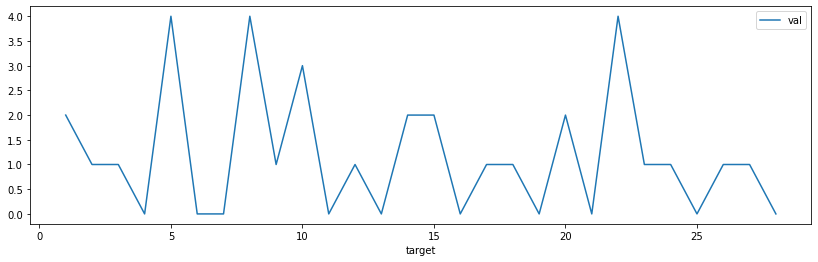

In [134]:
target_df.loc[target_df.id == "FOODS_1_001_CA_1", ["target", "val"]].set_index("target").plot()

In [135]:
fcst_cols = [f"fcst_{i}" for i in range(1, 29)]

In [139]:
fcst_df = pd.melt(val_tail[fcst_cols + id_cols], id_vars=id_cols, var_name="target", value_name="fcst")
fcst_df["target"] = fcst_df.target.str[-2:].str.replace("_", "").apply(int)
fcst_df = fcst_df.sort_values(by=["id", "target"])

In [144]:
res_df = target_df.join(fcst_df["fcst"])

In [145]:
res_df

,id,item_id,dept_id,cat_id,store_id,state_id,target,val,fcst
0,FOODS_1_001_CA_1,FOODS_1_001,FOODS_1,FOODS,CA_1,CA,1,2.0,0.950892
3049,FOODS_1_001_CA_1,FOODS_1_001,FOODS_1,FOODS,CA_1,CA,2,1.0,0.814176
6098,FOODS_1_001_CA_1,FOODS_1_001,FOODS_1,FOODS,CA_1,CA,3,1.0,0.959437
9147,FOODS_1_001_CA_1,FOODS_1_001,FOODS_1,FOODS,CA_1,CA,4,0.0,0.811811
12196,FOODS_1_001_CA_1,FOODS_1_001,FOODS_1,FOODS,CA_1,CA,5,4.0,1.057384
...,...,...,...,...,...,...,...,...,...
73175,HOUSEHOLD_2_516_CA_1,HOUSEHOLD_2_516,HOUSEHOLD_2,HOUSEHOLD,CA_1,CA,24,0.0,0.141423
76224,HOUSEHOLD_2_516_CA_1,HOUSEHOLD_2_516,HOUSEHOLD_2,HOUSEHOLD,CA_1,CA,25,1.0,0.147758
79273,HOUSEHOLD_2_516_CA_1,HOUSEHOLD_2_516,HOUSEHOLD_2,HOUSEHOLD,CA_1,CA,26,1.0,0.182502
82322,HOUSEHOLD_2_516_CA_1,HOUSEHOLD_2_516,HOUSEHOLD_2,HOUSEHOLD,CA_1,CA,27,0.0,0.250019


<AxesSubplot:xlabel='target'>

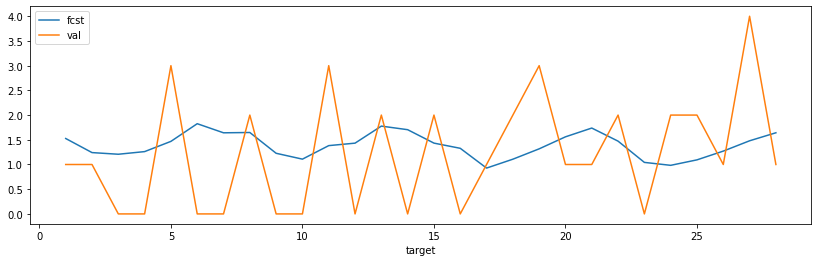

In [149]:
res_df.loc[res_df.id == "FOODS_1_005_CA_1", ["target", "fcst", "val"]].set_index("target").plot()

<AxesSubplot:xlabel='target'>

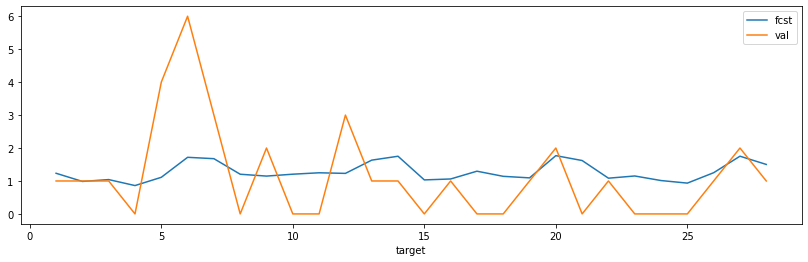

In [153]:
res_df.loc[res_df.id == "FOODS_1_050_CA_1", ["target", "fcst", "val"]].set_index("target").plot()

In [85]:
fcst_list = []
for iid in val_tail.id.unique():
    val_item = val_tail[val_tail.id == iid]
    df = pd.DataFrame()
    df[id_cols] = val_item[id_cols]
    df["d"] = val_item["d"]
    df["val"] = val_item["target_28"]
    df["fcst_"] = model_target[27].predict(val_item[feature_cols])
    fcst_list.append(df)

In [89]:
pd.concat(fcst_list)

,id,item_id,dept_id,cat_id,store_id,state_id,d,val,fcst_
45913622,FOODS_1_001_CA_1,FOODS_1_001,FOODS_1,FOODS,CA_1,CA,1913,0.0,1.173910
45913623,FOODS_1_002_CA_1,FOODS_1_002,FOODS_1,FOODS,CA_1,CA,1913,0.0,0.619798
45913624,FOODS_1_003_CA_1,FOODS_1_003,FOODS_1,FOODS,CA_1,CA,1913,0.0,1.148641
45913625,FOODS_1_004_CA_1,FOODS_1_004,FOODS_1,FOODS,CA_1,CA,1913,0.0,3.548228
45913626,FOODS_1_005_CA_1,FOODS_1_005,FOODS_1,FOODS,CA_1,CA,1913,1.0,1.641970
...,...,...,...,...,...,...,...,...,...
45913617,HOUSEHOLD_2_512_CA_1,HOUSEHOLD_2_512,HOUSEHOLD_2,HOUSEHOLD,CA_1,CA,1913,0.0,0.766675
45913618,HOUSEHOLD_2_513_CA_1,HOUSEHOLD_2_513,HOUSEHOLD_2,HOUSEHOLD,CA_1,CA,1913,3.0,0.446538
45913619,HOUSEHOLD_2_514_CA_1,HOUSEHOLD_2_514,HOUSEHOLD_2,HOUSEHOLD,CA_1,CA,1913,0.0,0.414865
45913620,HOUSEHOLD_2_515_CA_1,HOUSEHOLD_2_515,HOUSEHOLD_2,HOUSEHOLD,CA_1,CA,1913,0.0,0.101111


<AxesSubplot:xlabel='d'>

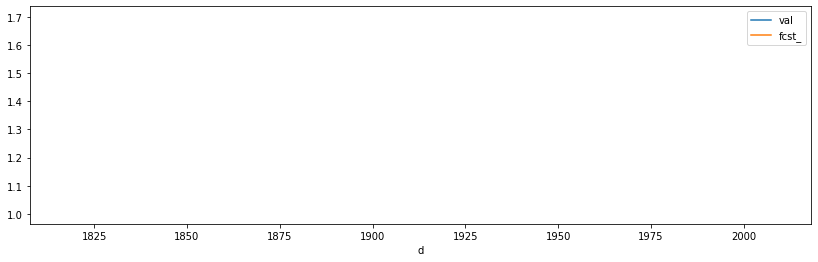

In [90]:
fcst_list[1000][["d", "val", "fcst_"]].set_index("d").plot()

In [83]:
pd.concat(fcst_list)

,id,item_id,dept_id,cat_id,store_id,state_id,d,val,fcst
45090392,FOODS_1_001_CA_1,FOODS_1_001,FOODS_1,FOODS,CA_1,CA,1886,2.0,0.510100
45120882,FOODS_1_001_CA_1,FOODS_1_001,FOODS_1,FOODS,CA_1,CA,1887,1.0,0.525889
45151372,FOODS_1_001_CA_1,FOODS_1_001,FOODS_1,FOODS,CA_1,CA,1888,1.0,0.513357
45181862,FOODS_1_001_CA_1,FOODS_1_001,FOODS_1,FOODS,CA_1,CA,1889,0.0,0.573321
45212352,FOODS_1_001_CA_1,FOODS_1_001,FOODS_1,FOODS,CA_1,CA,1890,4.0,0.684916
...,...,...,...,...,...,...,...,...,...
45791661,HOUSEHOLD_2_516_CA_1,HOUSEHOLD_2_516,HOUSEHOLD_2,HOUSEHOLD,CA_1,CA,1909,0.0,0.139438
45822151,HOUSEHOLD_2_516_CA_1,HOUSEHOLD_2_516,HOUSEHOLD_2,HOUSEHOLD,CA_1,CA,1910,1.0,0.126385
45852641,HOUSEHOLD_2_516_CA_1,HOUSEHOLD_2_516,HOUSEHOLD_2,HOUSEHOLD,CA_1,CA,1911,1.0,0.177661
45883131,HOUSEHOLD_2_516_CA_1,HOUSEHOLD_2_516,HOUSEHOLD_2,HOUSEHOLD,CA_1,CA,1912,0.0,0.200367


In [62]:
def prepare_fcst(ts):
    df = pd.DataFrame()
    df["d"] = ts["d"]
    df["val"] = ts["target_28"]
    df["fcst"] = model_target[27].predict(ts[feature_cols])
    return df

In [14]:
validation["sales_fcst"] = model.predict(validation.drop(columns=["sales"]))

In [15]:
ids = list(validation.id.unique())

<AxesSubplot:xlabel='d'>

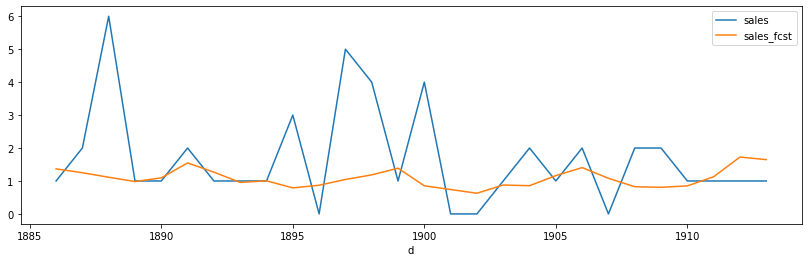

In [16]:
validation.loc[validation.id == ids[2100], ["d", "sales", "sales_fcst"]].set_index("d").plot()

In [30]:
y_train_df = train[train.id == "FOODS_1_002_CA_1"]
y_val_df = validation[validation.id == "FOODS_1_002_CA_1"]

In [33]:
N = len(y_train_df)
fh = len(y_val_df)

In [51]:
y_fcst = y_val_df["sales_fcst"]
y_val = y_val_df["sales"]
y_train = y_train_df["sales"]

In [52]:
fh = len(y_val)
n = len(y_train)

In [54]:
import numpy as np

In [62]:
y_val

45090393    0
45120883    1
45151373    0
45181863    0
45212353    0
45242843    0
45273333    0
45303823    0
45334313    0
45364803    1
45395293    0
45425783    0
45456273    0
45486763    0
45517253    1
45547743    0
45578233    0
45608723    1
45639213    1
45669703    3
45700193    1
45730683    0
45761173    0
45791663    1
45822153    2
45852643    0
45883133    0
45913623    0
Name: sales, dtype: int16

In [50]:
((diffs.iloc[1:])**2).mean()

1.1476656

In [47]:
(diffs**2).mean()

1.1476656

In [36]:
validation["sales_fcst"]

45090392    0.433301
45120882    0.299835
45151372    0.347306
45181862    0.357336
45212352    0.493686
              ...   
45791661    0.230610
45822151    0.199468
45852641    0.253876
45883131    0.343197
45913621    0.365945
Name: sales_fcst, Length: 85371, dtype: float64

In [18]:
err = validation["sales"] - validation["sales_fcst"]
diffs = validation["sales"].diff()
err**2 diffs**2

45090392    1.566699
45120882    0.700165
45151372    0.652694
45181862   -0.357336
45212352    3.506314
              ...   
45791661   -0.230610
45822151    0.800532
45852641    0.746124
45883131   -0.343197
45913621   -0.365945
Length: 85371, dtype: float64

In [106]:
global_fcst = validation.groupby(["d", "state_id"])[["sales", "sales_fcst"]].sum()

KeyError: 'state_id'

<AxesSubplot:xlabel='d'>

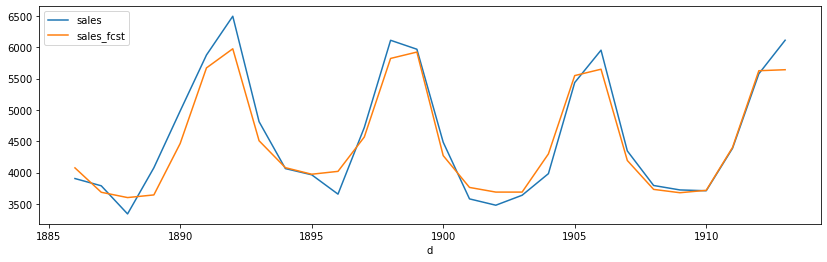

In [104]:
global_fcst.plot()

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

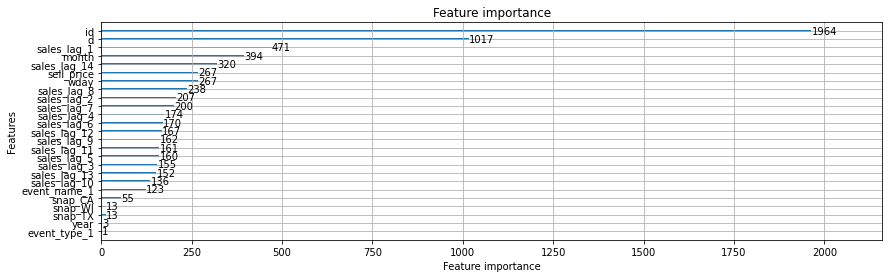

In [105]:
lgb.plot_importance(model)

In [87]:
val_gby = validation.groupby("id")[["id", "d", "sales", "sales_fcst"]]

,id,d,sales,sales_fcst
45090392,FOODS_1_001_CA_1,1886,2,0.433301
45120882,FOODS_1_001_CA_1,1887,1,0.299835
45151372,FOODS_1_001_CA_1,1888,1,0.347306
45181862,FOODS_1_001_CA_1,1889,0,0.357336
45212352,FOODS_1_001_CA_1,1890,4,0.493686
...,...,...,...,...
45791661,HOUSEHOLD_2_516_CA_1,1909,0,0.230610
45822151,HOUSEHOLD_2_516_CA_1,1910,1,0.199468
45852641,HOUSEHOLD_2_516_CA_1,1911,1,0.253876
45883131,HOUSEHOLD_2_516_CA_1,1912,0,0.343197


In [28]:
label = data["sales"]
data = d

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4571183 entries, 492423 to 45915058
Data columns (total 28 columns):
 #   Column        Dtype  
---  ------        -----  
 0   id            int16  
 1   d             int16  
 2   sales         int16  
 3   wday          int8   
 4   month         int8   
 5   year          int16  
 6   event_name_1  int8   
 7   event_type_1  int8   
 8   event_name_2  int8   
 9   event_type_2  int8   
 10  snap_CA       bool   
 11  snap_TX       bool   
 12  snap_WI       bool   
 13  sell_price    float32
 14  sales_lag_1   int16  
 15  sales_lag_2   int16  
 16  sales_lag_3   int16  
 17  sales_lag_4   int16  
 18  sales_lag_5   int16  
 19  sales_lag_6   int16  
 20  sales_lag_7   int16  
 21  sales_lag_8   int16  
 22  sales_lag_9   int16  
 23  sales_lag_10  int16  
 24  sales_lag_11  int16  
 25  sales_lag_12  int16  
 26  sales_lag_13  int16  
 27  sales_lag_14  int16  
dtypes: bool(3), float32(1), int16(18), int8(6)
memory usage: 248.5 MB


In [16]:
data_ca1.iloc[]

,id,item_id,dept_id,cat_id,store_id,state_id,d,sales,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price,sales_lag_1,sales_lag_2,sales_lag_3,sales_lag_4,sales_lag_5,sales_lag_6,sales_lag_7,sales_lag_8,sales_lag_9,sales_lag_10,sales_lag_11,sales_lag_12,sales_lag_13,sales_lag_14
492423,HOBBIES_1_008_CA_1,HOBBIES_1_008,HOBBIES_1,HOBBIES,CA_1,CA,42,0,7,3,2011,0,0,0,0,False,True,True,0.42,20,2,2,13,0,7,5,6,4,0,0,0,15,12
492424,HOBBIES_1_009_CA_1,HOBBIES_1_009,HOBBIES_1,HOBBIES,CA_1,CA,42,0,7,3,2011,0,0,0,0,False,True,True,1.56,0,1,3,4,0,0,9,3,2,0,3,7,0,2
492427,HOBBIES_1_015_CA_1,HOBBIES_1_015,HOBBIES_1,HOBBIES,CA_1,CA,42,1,7,3,2011,0,0,0,0,False,True,True,0.72,9,0,25,0,0,0,0,0,0,0,5,0,0,4
492428,HOBBIES_1_016_CA_1,HOBBIES_1_016,HOBBIES_1,HOBBIES,CA_1,CA,42,4,7,3,2011,0,0,0,0,False,True,True,0.72,2,1,1,0,7,2,5,1,32,15,0,3,1,5
492430,HOBBIES_1_022_CA_1,HOBBIES_1_022,HOBBIES_1,HOBBIES,CA_1,CA,42,0,7,3,2011,0,0,0,0,False,True,True,6.86,0,2,1,2,1,0,1,1,0,0,1,1,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45915054,FOODS_3_823_CA_1,FOODS_3_823,FOODS_3,FOODS,CA_1,CA,1913,1,2,4,2016,0,0,0,0,False,False,False,2.98,0,0,0,0,0,0,0,0,0,0,0,0,0,0
45915055,FOODS_3_824_CA_1,FOODS_3_824,FOODS_3,FOODS,CA_1,CA,1913,0,2,4,2016,0,0,0,0,False,False,False,2.48,0,0,0,0,0,0,0,0,0,0,0,0,0,0
45915056,FOODS_3_825_CA_1,FOODS_3_825,FOODS_3,FOODS,CA_1,CA,1913,2,2,4,2016,0,0,0,0,False,False,False,3.98,1,0,1,1,1,0,2,2,0,0,0,1,0,3
45915057,FOODS_3_826_CA_1,FOODS_3_826,FOODS_3,FOODS,CA_1,CA,1913,0,2,4,2016,0,0,0,0,False,False,False,1.28,0,0,3,0,3,2,4,3,2,1,1,0,4,0


In [79]:
event_columns = ["event_name_1", "event_type_1", "event_name_2", "event_type_2"]
data_ca1[event_columns] = data_ca1[event_columns].astype("int8")

In [87]:
data_ca1["event_name_2"].max()

4

In [80]:
data_ca1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4571183 entries, 492423 to 45915058
Data columns (total 34 columns):
 #   Column        Dtype         
---  ------        -----         
 0   id            category      
 1   item_id       category      
 2   dept_id       category      
 3   cat_id        category      
 4   store_id      category      
 5   state_id      category      
 6   d             int16         
 7   date          datetime64[ns]
 8   sales         int16         
 9   wday          int8          
 10  month         int8          
 11  year          int16         
 12  event_name_1  int8          
 13  event_type_1  int8          
 14  event_name_2  int8          
 15  event_type_2  int8          
 16  snap_CA       bool          
 17  snap_TX       bool          
 18  snap_WI       bool          
 19  sell_price    float32       
 20  sales_lag_1   int16         
 21  sales_lag_2   int16         
 22  sales_lag_3   int16         
 23  sales_lag_4   int16       

In [68]:
y = ds[0]

In [73]:
len(ds[1])

31

In [70]:
y[y!=0]

array([ 1,  1,  1, ..., 30, 30, 30])

In [57]:
daata_aca1.

,id,item_id,dept_id,cat_id,store_id,state_id,d,date,sales,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price,sales_lag_1,sales_lag_2,sales_lag_3,sales_lag_4,sales_lag_5,sales_lag_6,sales_lag_7,sales_lag_8,sales_lag_9,sales_lag_10,sales_lag_11,sales_lag_12,sales_lag_13,sales_lag_14
492423,HOBBIES_1_008_CA_1,HOBBIES_1_008,HOBBIES_1,HOBBIES,CA_1,CA,42,2011-03-11,0,7,3,2011,NoEvent,NoEvent,NoEvent,NoEvent,False,True,True,0.42,20,2,2,13,0,7,5,6,4,0,0,0,15,12
492424,HOBBIES_1_009_CA_1,HOBBIES_1_009,HOBBIES_1,HOBBIES,CA_1,CA,42,2011-03-11,0,7,3,2011,NoEvent,NoEvent,NoEvent,NoEvent,False,True,True,1.56,0,1,3,4,0,0,9,3,2,0,3,7,0,2
492427,HOBBIES_1_015_CA_1,HOBBIES_1_015,HOBBIES_1,HOBBIES,CA_1,CA,42,2011-03-11,1,7,3,2011,NoEvent,NoEvent,NoEvent,NoEvent,False,True,True,0.72,9,0,25,0,0,0,0,0,0,0,5,0,0,4
492428,HOBBIES_1_016_CA_1,HOBBIES_1_016,HOBBIES_1,HOBBIES,CA_1,CA,42,2011-03-11,4,7,3,2011,NoEvent,NoEvent,NoEvent,NoEvent,False,True,True,0.72,2,1,1,0,7,2,5,1,32,15,0,3,1,5
492430,HOBBIES_1_022_CA_1,HOBBIES_1_022,HOBBIES_1,HOBBIES,CA_1,CA,42,2011-03-11,0,7,3,2011,NoEvent,NoEvent,NoEvent,NoEvent,False,True,True,6.86,0,2,1,2,1,0,1,1,0,0,1,1,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45915054,FOODS_3_823_CA_1,FOODS_3_823,FOODS_3,FOODS,CA_1,CA,1913,2016-04-24,1,2,4,2016,NoEvent,NoEvent,NoEvent,NoEvent,False,False,False,2.98,0,0,0,0,0,0,0,0,0,0,0,0,0,0
45915055,FOODS_3_824_CA_1,FOODS_3_824,FOODS_3,FOODS,CA_1,CA,1913,2016-04-24,0,2,4,2016,NoEvent,NoEvent,NoEvent,NoEvent,False,False,False,2.48,0,0,0,0,0,0,0,0,0,0,0,0,0,0
45915056,FOODS_3_825_CA_1,FOODS_3_825,FOODS_3,FOODS,CA_1,CA,1913,2016-04-24,2,2,4,2016,NoEvent,NoEvent,NoEvent,NoEvent,False,False,False,3.98,1,0,1,1,1,0,2,2,0,0,0,1,0,3
45915057,FOODS_3_826_CA_1,FOODS_3_826,FOODS_3,FOODS,CA_1,CA,1913,2016-04-24,0,2,4,2016,NoEvent,NoEvent,NoEvent,NoEvent,False,False,False,1.28,0,0,3,0,3,2,4,3,2,1,1,0,4,0


In [55]:
dataset = lgb.Dataset(data_ca1)

In [56]:
dataset.construct()

ValueError: DataFrame.dtypes for data must be int, float or bool.
Did not expect the data types in the following fields: date